# Import libraries

In [1]:
import sklearn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from eli5 import show_weights, show_prediction
import seaborn as sns
from sklearn.manifold import TSNE
import os
import pandas as pd

#custom
from py.helper import DataProcessing
from py.ml_metrics import evaluate_model, multiclass_logloss
from py.plotting import plot_tsne

/home/aneesh/Projects/covid_bh_ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/aneesh/Projects/covid_bh_ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [2]:
# set K-mer length here
kmer = 4


In [3]:
rvdb14 = DataProcessing('RVDB14_complete_coronavirus_fixed.fasta', 'RVDB14_Coronavirus_meta_data_human_pathogen.csv')

In [4]:
# #this will take a while
# # kmers = orf1.get_amino_kmer_df(4)
# amino_df = orf1.get_amino_df(kmer)
# print(amino_df.shape)

# # get rid of duplicates
# amino_df.drop_duplicates(subset='Accession', keep=False, inplace=True)
# print(amino_df.shape)
# amino_df.head()

In [5]:
label_df = rvdb14.get_meta_df('tsv')
label_df.head()

,accession,label
0,KM349744.1,0
1,KJ156866.1,1
2,KM027262.1,1
3,NC_028806.1,0
4,AY545916.1,1


In [6]:
fasta_df = rvdb14.get_fasta__df()
fasta_df.head()

[SeqRecord(seq=Seq('ACTTTTAAAGATAAGTGAGTGTAGCGTAGCTGCCTACTTTCTTTAACTTGACTC...AAA', SingleLetterAlphabet()), id='acc|REFSEQ|NC_030292.1|Ferret', name='acc|REFSEQ|NC_030292.1|Ferret', description='acc|REFSEQ|NC_030292.1|Ferret coronavirus isolate FRCoV-NL-2010, complete genome', dbxrefs=[])]


,seq,id,description
0,ACTTTTAAAGATAAGTGAGTGTAGCGTAGCTGCCTACTTTCTTTAA...,acc|REFSEQ|NC_030292.1|Ferret,acc|REFSEQ|NC_030292.1|Ferret coronavirus isol...
1,ACTTAAGTGTCTTATCTATCTATAGATAGAAAAGTCGCTTTTTAGA...,acc|REFSEQ|NC_028752.1|Camel,acc|REFSEQ|NC_028752.1|Camel alphacoronavirus ...
2,AGTAAAGTGAGTGTAGCGTGGCTATATCTCTTCTTTTACTTTAACT...,acc|REFSEQ|NC_028806.1|Swine,acc|REFSEQ|NC_028806.1|Swine enteric coronavir...
3,AAGTGTCGTGCTCCTAGGGGTTGCACTTGACGTGTTCCGTCACGTA...,"acc|REFSEQ|NC_028824.1|BtRf-AlphaCoV_YN2012,","acc|REFSEQ|NC_028824.1|BtRf-AlphaCoV_YN2012, a..."
4,GGCCCCCATGGCTAGCAACCGTATTTCGTTGGCTTTTGCCAATGAT...,"acc|REFSEQ|NC_028814.1|BtRf-AlphaCoV_HuB2013,","acc|REFSEQ|NC_028814.1|BtRf-AlphaCoV_HuB2013, ..."


In [7]:
label_df.drop_duplicates(subset='accession', keep=False, inplace=True)
label_df.info()
# label_df['accession'] = label_df['accession'].apply(str)
# fasta_df['id'] = fasta_df['id'].apply(str)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2349 entries, 0 to 2348
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   accession  2349 non-null   object
 1   label      2349 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 55.1+ KB


In [8]:
fasta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   seq          2278 non-null   object
 1   id           2278 non-null   object
 2   description  2278 non-null   object
dtypes: object(3)
memory usage: 53.5+ KB


# Filter rows
- the length of label df is greater than that of fasta_df

In [9]:
# labels df and fasta df have different lengths, so we need filter out those with labels
filtered_fa = [i for i in fasta_df['id'] for j in label_df['accession'] if j in i]


filtered_la = [i for i in label_df['accession'] for j in filtered_fa if i in j]
print(len(filtered_fa))

2278


In [10]:
# drop the rows from fasta-table for which no labels are available
fasta_df['label'] = ''
for index, row in fasta_df.iterrows():
    if row['id'] not in set(filtered_fa):
        fasta_df.drop(index, inplace=True)
        
# insert accession numbers to fasta-table     
fasta_df['accession'] = fasta_df['id']
fasta_df['accession'] = fasta_df['accession'].apply(lambda x: x.split('|')[2])
        
# drop the all the labels that are not part of fasta-table
for index, row in label_df.iterrows():
    if row['accession'] not in set(filtered_la):
        label_df.drop(index, inplace=True)
        
# copy the labels form labels-table to fasta-table    
fasta_df.loc[fasta_df.accession.isin(label_df.accession), ['label']] = label_df[['label']]



In [11]:
label_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2348
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   accession  2278 non-null   object
 1   label      2278 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 133.4+ KB


In [12]:
fasta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   seq          2278 non-null   object
 1   id           2278 non-null   object
 2   description  2278 non-null   object
 3   label        2207 non-null   object
 4   accession    2278 non-null   object
dtypes: object(5)
memory usage: 89.1+ KB


In [13]:
print(fasta_df.shape)
fasta_df.head()

(2278, 5)


,seq,id,description,label,accession
0,ACTTTTAAAGATAAGTGAGTGTAGCGTAGCTGCCTACTTTCTTTAA...,acc|REFSEQ|NC_030292.1|Ferret,acc|REFSEQ|NC_030292.1|Ferret coronavirus isol...,0,NC_030292.1
1,ACTTAAGTGTCTTATCTATCTATAGATAGAAAAGTCGCTTTTTAGA...,acc|REFSEQ|NC_028752.1|Camel,acc|REFSEQ|NC_028752.1|Camel alphacoronavirus ...,1,NC_028752.1
2,AGTAAAGTGAGTGTAGCGTGGCTATATCTCTTCTTTTACTTTAACT...,acc|REFSEQ|NC_028806.1|Swine,acc|REFSEQ|NC_028806.1|Swine enteric coronavir...,1,NC_028806.1
3,AAGTGTCGTGCTCCTAGGGGTTGCACTTGACGTGTTCCGTCACGTA...,"acc|REFSEQ|NC_028824.1|BtRf-AlphaCoV_YN2012,","acc|REFSEQ|NC_028824.1|BtRf-AlphaCoV_YN2012, a...",0,NC_028824.1
4,GGCCCCCATGGCTAGCAACCGTATTTCGTTGGCTTTTGCCAATGAT...,"acc|REFSEQ|NC_028814.1|BtRf-AlphaCoV_HuB2013,","acc|REFSEQ|NC_028814.1|BtRf-AlphaCoV_HuB2013, ...",1,NC_028814.1


In [14]:
# remove nans
fasta_df.dropna(inplace=True)

#save
fasta_df.to_csv(os.path.join(rvdb14.data_path, 'RVDB14_complete_coronavirus_fixed.fasta.csv'), header=True, index=False)

# Load cleaned data

In [25]:
cleaned_path = os.path.join(rvdb14.data_path, 'RVDB14_complete_coronavirus_fixed.fasta.csv')

cleaned_df = pd.read_csv(cleaned_path, dtype={'label':int})
# remove nans
cleaned_df.dropna(inplace=True)

# remove artifacts
for index, row in cleaned_df.iterrows():
    if row['label'] < 0:
        cleaned_df.drop(index, inplace=True)
cleanded_df = cleaned_df[cleaned_df['label'] >= 0]
cleaned_df.head()

,seq,id,description,label,accession
0,ACTTTTAAAGATAAGTGAGTGTAGCGTAGCTGCCTACTTTCTTTAA...,acc|REFSEQ|NC_030292.1|Ferret,acc|REFSEQ|NC_030292.1|Ferret coronavirus isol...,0,NC_030292.1
1,ACTTAAGTGTCTTATCTATCTATAGATAGAAAAGTCGCTTTTTAGA...,acc|REFSEQ|NC_028752.1|Camel,acc|REFSEQ|NC_028752.1|Camel alphacoronavirus ...,1,NC_028752.1
2,AGTAAAGTGAGTGTAGCGTGGCTATATCTCTTCTTTTACTTTAACT...,acc|REFSEQ|NC_028806.1|Swine,acc|REFSEQ|NC_028806.1|Swine enteric coronavir...,1,NC_028806.1
3,AAGTGTCGTGCTCCTAGGGGTTGCACTTGACGTGTTCCGTCACGTA...,"acc|REFSEQ|NC_028824.1|BtRf-AlphaCoV_YN2012,","acc|REFSEQ|NC_028824.1|BtRf-AlphaCoV_YN2012, a...",0,NC_028824.1
4,GGCCCCCATGGCTAGCAACCGTATTTCGTTGGCTTTTGCCAATGAT...,"acc|REFSEQ|NC_028814.1|BtRf-AlphaCoV_HuB2013,","acc|REFSEQ|NC_028814.1|BtRf-AlphaCoV_HuB2013, ...",1,NC_028814.1


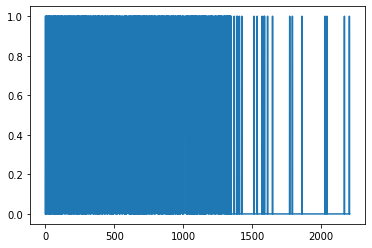

In [26]:
cleaned_df['label'].plot()

In [27]:
cleaned_df['label'].unique()

array([0, 1])

In [28]:
# min and max length of sequences
max_len = max(len(s) for s in cleaned_df['seq'])
min_len =min(len(s) for s in cleaned_df['seq'])
print(f"Sequence length - max:{max_len}, min:{min_len}")

Sequence length - max:31775, min:25320


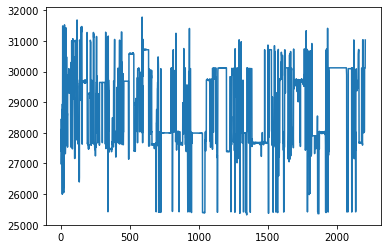

In [29]:
plt.plot([len(s) for s in cleaned_df['seq']])

In [30]:
# find letter representations
letters = []
[letters.extend(list(i)) for i in  cleaned_df['seq']]
len_letters = len(set(letters))
len_letters

13

# deep learning with convolutional neural nets

In [31]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from numpy import array

# The LabelEncoder encodes a sequence of residues as a sequence of integers.
integer_encoder = LabelEncoder()
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')

#fit one-hot encorder with all neucleotides
integer_cat_arr = np.array(list(range(len_letters))).reshape(-1, 1)
one_hot_encoder = one_hot_encoder.fit(integer_cat_arr)
sequences = [i[:min_len] for i in cleaned_df['seq']]

#fit the label encoder with all the nucleotides
integer_encoder = integer_encoder.fit(list(''.join(sequences)))
input_features = []
int_encoded = [] # for LSTM

for sequence in sequences:
  integer_encoded = integer_encoder.transform(list(sequence))
  int_encoded.append(integer_encoded)
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

int_encoded = array(int_encoded)
print(int_encoded)
np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('nucleotude Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

[[0 1 9 ... 1 9 9]
 [0 1 9 ... 0 1 9]
 [0 3 9 ... 0 1 0]
 ...
 [3 0 9 ... 0 9 9]
 [3 0 9 ... 0 9 9]
 [3 0 9 ... 3 0 3]]
Example sequence
-----------------------
nucleotude Sequence #1:
 ACTTTTAAAG ... TGCCAGACTT
One hot encoding of Sequence #1:
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [32]:
one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(cleaned_df['label']).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)
input_labels.shape

Labels:
 [[0 1 1 ... 1 0 0]]
One-hot encoded labels:
 [[1. 0. 0. ... 0. 1. 1.]
 [0. 1. 1. ... 1. 0. 0.]]


(2206, 2)

In [33]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.2, random_state=42)

In [34]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3,input_shape=(train_features.shape[1], 13)))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 25318, 32)         1280      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 6329, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 202528)            0         
_________________________________________________________________
dense (Dense)                (None, 16)                3240464   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 3,241,778
Trainable params: 3,241,778
Non-trainable params: 0
_________________________________________________________________


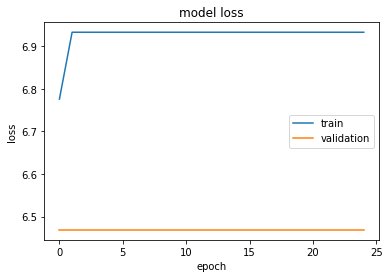

In [35]:
history = model.fit(train_features, train_labels, epochs=25, verbose=0, validation_split=0.25, shuffle=True)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

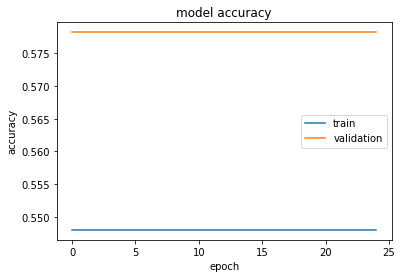

In [48]:
plt.figure()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

In [42]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [47]:
tf.__version__

'2.1.0'

In [45]:
tf.config.list_physical_devices('GPU')

[]

AttributeError: module 'tensorflow_core._api.v2.config' has no attribute 'experimental_list_devices'